In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier 
import optuna
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import joblib

# Multi Label Classification
This means that each row can correspondd to multiple target classes, and the target may have an interelationship with each other

In [2]:
%%capture
pip install iterative-stratification

In [3]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

## Reading in the data

In [4]:
train = pd.read_csv("/kaggle/input/playground-series-s4e3/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e3/test.csv")
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)

In [5]:
target_cols=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps','Other_Faults']
train = train[train[target_cols].sum(axis=1) == 1]

# TSN-3
### To create insights into our data
We perform dimensionality reduction using tsn-3 for non linear relationships and plot the two components while mapping our target features to different colors

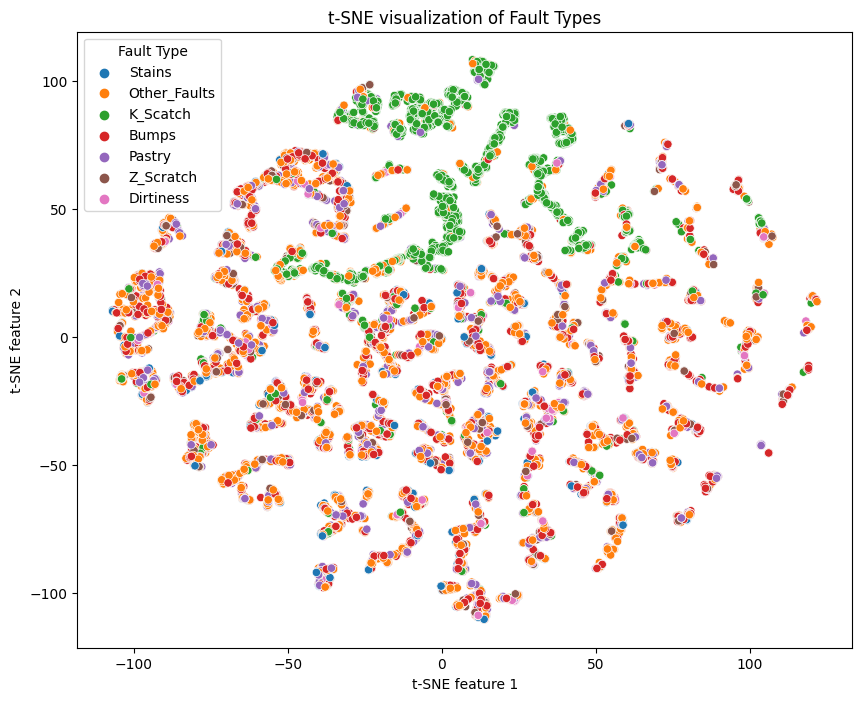

In [6]:
"""
Performaing tsn-3 and visualizing patterns and trends within the data to identicy relationships with teh target features.
Clear clusters of data points with the same color, indicatied that our model will be able to recognize patterns and relationships
to classify the targets well.
"""

train2 = pd.read_csv("/kaggle/input/playground-series-s4e3/train.csv").drop(columns=['id'], axis=1)
train2['target'] = pd.Series(train2[target_cols].idxmax(axis=1))
# Separating features and labels
X3 = train2.drop(columns=target_cols + ['target'], axis=1)
y3 = train2['target']

# Performing t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
X_tsne = tsne.fit_transform(X3)

# Creating a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y3, legend='full')
plt.title('t-SNE visualization of Fault Types')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(title='Fault Type')
plt.show()

From the looks of it. We can only really visualize one distinct cluster of ddatapoints corresponding to K_scratch. This tells us that our models probably will achieve higher scores for predicting K_scratch while it may be difficult for the models to predict the other classes

## Feature Generation
We generate additional features with the aim of capturing additional patterns in our data

In [7]:
def feature_generator(data):

    "A function to generate additional features"

    epsilon = 1e-6  # A small constant to avoid division by zero or taking the logarithm of zero
    # Location Features
    data['X_Distance'] = data['X_Maximum'] - data['X_Minimum']
    data['Y_Distance'] = data['Y_Maximum'] - data['Y_Minimum']

    # Density Feature
    data['Density'] = data['Pixels_Areas'] / (data['X_Perimeter'] + data['Y_Perimeter'])

    # Relative Perimeter Feature
    data['Relative_Perimeter'] = data['X_Perimeter'] / (data['X_Perimeter'] + data['Y_Perimeter'] + epsilon)

    # Circularity Feature
    data['Circularity'] = data['Pixels_Areas'] / (data['X_Perimeter'] ** 2)

    # Symmetry Index Feature
    data['Symmetry_Index'] = np.abs(data['X_Distance'] - data['Y_Distance']) / (data['X_Distance'] + data['Y_Distance'] + epsilon)
    
    # Color Contrast Feature
    data['Color_Contrast'] = data['Maximum_of_Luminosity'] - data['Minimum_of_Luminosity']

    # Combined Geometric Index Feature
    data['Combined_Geometric_Index'] = data['Edges_Index'] * data['Square_Index']

    # Interaction Term Feature
    data['X_Distance*Pixels_Areas'] = data['X_Distance'] * data['Pixels_Areas']
    
    # Additional Features
    data['sin_orientation'] = np.sin(data['Orientation_Index'])
    data['Edges_Index2'] = np.exp(data['Edges_Index'] + epsilon)
    data['X_Maximum2'] = np.sin(data['X_Maximum'])
    data['Y_Minimum2'] = np.sin(data['Y_Minimum'])
    data['Aspect_Ratio_Pixels'] = np.where(data['Y_Perimeter'] == 0, 0, data['X_Perimeter'] / data['Y_Perimeter'])
    data['Aspect_Ratio'] = np.where(data['Y_Distance'] == 0, 0, data['X_Distance'] / data['Y_Distance'])

    # Average Luminosity Feature
    data['Average_Luminosity'] = (data['Sum_of_Luminosity'] + data['Minimum_of_Luminosity']) / 2
    
    # Normalized Steel Thickness Feature
    data['Normalized_Steel_Thickness'] = (data['Steel_Plate_Thickness'] - data['Steel_Plate_Thickness'].min()) / (data['Steel_Plate_Thickness'].max() - data['Steel_Plate_Thickness'].min())

    # Logarithmic Features
    data['Log_Perimeter'] = np.log(data['X_Perimeter'] + data['Y_Perimeter'] + epsilon)
    data['Log_Luminosity'] = np.log(data['Sum_of_Luminosity'] + epsilon)
    data['Log_Aspect_Ratio'] = np.log(data['Aspect_Ratio'] ** 2 + epsilon)

    # Statistical Features
    data['Combined_Index'] = data['Orientation_Index'] * data['Luminosity_Index']
    data['Sigmoid_Areas'] = 1 / (1 + np.exp(-data['LogOfAreas'] + epsilon))

    return data

train = feature_generator(train)
test = feature_generator(test)

### Scaling our continuous features
We use a Robust Scaler which scales the features according to the interquartile ranges. This scaler is known for dealing with unbalances data

In [8]:
# Initialize the scaler
scaler = RobustScaler()

# Identify discrete features
discrete_features = ['TypeOfSteel_A300', 'TypeOfSteel_A400']

# Identify continuous features
continuous_features = [col for col in train.columns if col not in discrete_features + target_cols]

# Fit and transform the scaler on training data
train[continuous_features] = scaler.fit_transform(train[continuous_features])

# Transform the test data using the scaler fitted on training data
test[continuous_features] = scaler.transform(test[continuous_features])

# Specify our X and y

In [9]:
X = train.drop(columns=target_cols, axis=1)
y = train[target_cols]

# Initial Model Testing
We test out the three different ML models and see which one initially produces the highest ROC score. This lets us know which model that captures the underlying patterns within the data best.

[LightGBM] [Info] Number of positive: 1172, number of negative: 13532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10395
[LightGBM] [Info] Number of data points in the train set: 14704, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079706 -> initscore=-2.446346
[LightGBM] [Info] Start training from score -2.446346
[LightGBM] [Info] Number of positive: 920, number of negative: 13784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10395
[LightGBM] [Info] Number of data points in the train set: 14704, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062568 -> initscore=-2.706890
[LightGBM] [Info] Start training from score -2.706890
[LightGBM] [I

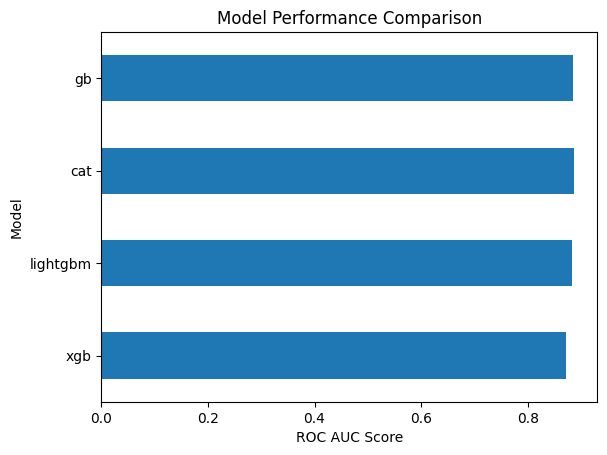

In [10]:
# MultiLabel
xgb = MultiOutputClassifier(XGBClassifier())
lightgm = MultiOutputClassifier(LGBMClassifier())
cat = MultiOutputClassifier(CatBoostClassifier(verbose=False))
gb = MultiOutputClassifier(GradientBoostingClassifier())


mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = [np.mean(cross_val_score(xgb, X, y, cv=mskf, scoring = "roc_auc")), 
         np.mean(cross_val_score(lightgm, X, y, cv=mskf, scoring = "roc_auc")),
         np.mean(cross_val_score(cat, X, y, cv=mskf, scoring = "roc_auc")),
         np.mean(cross_val_score(gb, X, y, cv=mskf, scoring = "roc_auc"))]

# Create a DataFrame to store model names and their corresponding scores
models = ["xgb", "lightgbm", "cat", "gb"]
model_scores = pd.DataFrame(list(zip(models, scores)), columns=["Model", "ROC AUC Score"])

# Plot the scores
model_scores.plot(kind='barh', x='Model', legend=False)
plt.xlabel('ROC AUC Score')
plt.ylabel('Model')
plt.title('Model Performance Comparison')
plt.show()

In [11]:
model_scores

,Model,ROC AUC Score
0,xgb,0.872827
1,lightgbm,0.883523
2,cat,0.886575
3,gb,0.884958


# Hyperparameter tuning
My strategy is to hyperparameter tune each model for a binary classification, were each models parameters are optimized for each target. So there will be 7 different sets of parameters for each model. See the hyperparameter tuning notebook.

# We compare the scores across every model across every target

In [12]:
model = joblib.load('/kaggle/input/models/models/best_cat_model_Bumps.pkl')

In [13]:
# Define the path to the directory containing the models
models_dir = '/kaggle/input/models/models/'

# List of model names
model_names = [
    "best_cat_model_Bumps.pkl",
    "best_cat_model_Dirtiness.pkl",
    "best_cat_model_K_Scatch.pkl",
    "best_cat_model_Other_Faults.pkl",
    "best_cat_model_Pastry.pkl",
    "best_cat_model_Stains.pkl",
    "best_cat_model_Z_Scratch.pkl",
    "best_lightgbm_model_Bumps.pkl",
    "best_lightgbm_model_Dirtiness.pkl",
    "best_lightgbm_model_K_Scatch.pkl",
    "best_lightgbm_model_Other_Faults.pkl",
    "best_lightgbm_model_Pastry.pkl",
    "best_lightgbm_model_Stains.pkl",
    "best_lightgbm_model_Z_Scratch.pkl",
    "best_xmodel_Bumps.pkl",
    "best_xmodel_Dirtiness.pkl",
    "best_xmodel_K_Scatch.pkl",
    "best_xmodel_Other_Faults.pkl",
    "best_xmodel_Pastry.pkl",
    "best_xmodel_Stains.pkl",
    "best_xmodel_Z_Scratch.pkl"
]

# Dictionary to store models
loaded_models = {}

# Load each model
for model_name in model_names:
    model_path = models_dir + model_name  # Corrected path concatenation
    model = joblib.load(model_path)
    loaded_models[model_name] = model

# Ensure that the model dictionary is sorted the same way as target_cols
models = {}
for target, model_name in zip(target_cols, model_names):
    models[target] = loaded_models[model_name]

In [14]:
X = train.drop(columns=target_cols, axis=1)
y1 = train['Pastry']
y2 = train['Z_Scratch']
y3 = train['K_Scatch']
y4 = train['Stains']
y5 = train['Dirtiness']
y6 = train['Bumps']
y7 = train['Other_Faults']

X_train_Pastry, X_test_Pastry, y_train_Pastry, y_test_Pastry = train_test_split(X, y1, test_size=0.3, random_state=24)
X_train_Z_Scratch, X_test_Z_Scratch, y_train_Z_Scratch, y_test_Z_Scratch = train_test_split(X, y2, test_size=0.3, random_state=24)
X_train_K_Scatch, X_test_K_Scatch, y_train_K_Scatch, y_test_K_Scatch = train_test_split(X, y3, test_size=0.3, random_state=24)
X_train_Stains, X_test_Stains, y_train_Stains, y_test_Stains = train_test_split(X, y4, test_size=0.3, random_state=24)
X_train_Dirtiness, X_test_Dirtiness, y_train_Dirtiness, y_test_Dirtiness = train_test_split(X, y5, test_size=0.3, random_state=24)
X_train_Bumps, X_test_Bumps, y_train_Bumps, y_test_Bumps = train_test_split(X, y6, test_size=0.3, random_state=24)
X_train_Other_Faults, X_test_Other_Faults, y_train_Other_Faults, y_test_Other_Faults = train_test_split(X, y7, test_size=0.3, random_state=24)

In [15]:
best_cat_model_Bumps = joblib.load('/kaggle/input/models/models/best_cat_model_Bumps.pkl')
best_cat_model_Dirtiness = joblib.load('/kaggle/input/models/models/best_cat_model_Dirtiness.pkl')
best_cat_model_K_Scatch = joblib.load('/kaggle/input/models/models/best_cat_model_K_Scatch.pkl')
best_cat_model_Other_Faults = joblib.load('/kaggle/input/models/models/best_cat_model_Other_Faults.pkl')
best_cat_model_Pastry = joblib.load('/kaggle/input/models/models/best_cat_model_Pastry.pkl')
best_cat_model_Stains = joblib.load('/kaggle/input/models/models/best_cat_model_Stains.pkl')
best_cat_model_Z_Scratch = joblib.load('/kaggle/input/models/models/best_cat_model_Z_Scratch.pkl')

best_lgbm_model_Bumps = joblib.load('/kaggle/input/models/models/best_lightgbm_model_Bumps.pkl')
best_lgbm_model_Dirtiness = joblib.load('/kaggle/input/models/models/best_lightgbm_model_Dirtiness.pkl')
best_lgbm_model_K_Scatch = joblib.load('/kaggle/input/models/models/best_lightgbm_model_K_Scatch.pkl')
best_lgbm_model_Other_Faults = joblib.load('/kaggle/input/models/models/best_lightgbm_model_Other_Faults.pkl')
best_lgbm_model_Pastry = joblib.load('/kaggle/input/models/models/best_lightgbm_model_Pastry.pkl')
best_lgbm_model_Stains = joblib.load('/kaggle/input/models/models/best_lightgbm_model_Stains.pkl')
best_lgbm_model_Z_Scratch = joblib.load('/kaggle/input/models/models/best_lightgbm_model_Z_Scratch.pkl')

best_xgb_model_Bumps = joblib.load('/kaggle/input/models/models/best_xmodel_Bumps.pkl')
best_xgb_model_Dirtiness = joblib.load('/kaggle/input/models/models/best_xmodel_Dirtiness.pkl')
best_xgb_model_K_Scatch = joblib.load('/kaggle/input/models/models/best_xmodel_K_Scatch.pkl')
best_xgb_model_Other_Faults = joblib.load('/kaggle/input/models/models/best_xmodel_Other_Faults.pkl')
best_xgb_model_Pastry = joblib.load('/kaggle/input/models/models/best_xmodel_Pastry.pkl')
best_xgb_model_Stains = joblib.load('/kaggle/input/models/models/best_xmodel_Stains.pkl')
best_xgb_model_Z_Scratch = joblib.load('/kaggle/input/models/models/best_xmodel_Z_Scratch.pkl')

In [16]:
best_cat_model_Bumps.fit(X_train_Bumps, y_train_Bumps)
cat_Bumps_preds = best_cat_model_Bumps.predict_proba(X_test_Bumps)[:, 1]
cat_Bumps_score = roc_auc_score(y_test_Bumps, cat_Bumps_preds)

best_cat_model_Dirtiness.fit(X_train_Dirtiness, y_train_Dirtiness)
cat_Dirtiness_preds = best_cat_model_Dirtiness.predict_proba(X_test_Dirtiness)[:, 1]
cat_Dirtiness_score = roc_auc_score(y_test_Dirtiness, cat_Dirtiness_preds)

best_cat_model_K_Scatch.fit(X_train_K_Scatch, y_train_K_Scatch)
cat_K_Scatch_preds = best_cat_model_K_Scatch.predict_proba(X_test_K_Scatch)[:, 1]
cat_K_Scatch_score = roc_auc_score(y_test_K_Scatch, cat_K_Scatch_preds)

best_cat_model_Other_Faults.fit(X_train_Other_Faults, y_train_Other_Faults)
cat_Other_Faults_preds = best_cat_model_Other_Faults.predict_proba(X_test_Other_Faults)[:, 1]
cat_Other_Faults_score = roc_auc_score(y_test_Other_Faults, cat_Other_Faults_preds)

best_cat_model_Pastry.fit(X_train_Pastry, y_train_Pastry)
cat_Pastry_preds = best_cat_model_Pastry.predict_proba(X_test_Pastry)[:, 1]
cat_Pastry_score = roc_auc_score(y_test_Pastry, cat_Pastry_preds)

best_cat_model_Stains.fit(X_train_Stains, y_train_Stains)
cat_Stains_preds = best_cat_model_Stains.predict_proba(X_test_Stains)[:, 1]
cat_Stains_score = roc_auc_score(y_test_Stains, cat_Stains_preds)

best_cat_model_Z_Scratch.fit(X_train_Z_Scratch, y_train_Z_Scratch)
cat_Z_Scratch_preds = best_cat_model_Z_Scratch.predict_proba(X_test_Z_Scratch)[:, 1]
cat_Z_Scratch_score = roc_auc_score(y_test_Z_Scratch, cat_Z_Scratch_preds)

In [17]:
best_lgbm_model_Bumps.fit(X_train_Bumps, y_train_Bumps)
lgbm_Bumps_preds = best_lgbm_model_Bumps.predict_proba(X_test_Bumps)[:, 1]
lgbm_Bumps_score = roc_auc_score(y_test_Bumps, lgbm_Bumps_preds)

best_lgbm_model_Dirtiness.fit(X_train_Dirtiness, y_train_Dirtiness)
lgbm_Dirtiness_preds = best_lgbm_model_Dirtiness.predict_proba(X_test_Dirtiness)[:, 1]
lgbm_Dirtiness_score = roc_auc_score(y_test_Dirtiness, lgbm_Dirtiness_preds)

best_lgbm_model_K_Scatch.fit(X_train_K_Scatch, y_train_K_Scatch)
lgbm_K_Scatch_preds = best_lgbm_model_K_Scatch.predict_proba(X_test_K_Scatch)[:, 1]
lgbm_K_Scatch_score = roc_auc_score(y_test_K_Scatch, lgbm_K_Scatch_preds)

best_lgbm_model_Other_Faults.fit(X_train_Other_Faults, y_train_Other_Faults)
lgbm_Other_Faults_preds = best_lgbm_model_Other_Faults.predict_proba(X_test_Other_Faults)[:, 1]
lgbm_Other_Faults_score = roc_auc_score(y_test_Other_Faults, lgbm_Other_Faults_preds)

best_lgbm_model_Pastry.fit(X_train_Pastry, y_train_Pastry)
lgbm_Pastry_preds = best_lgbm_model_Pastry.predict_proba(X_test_Pastry)[:, 1]
lgbm_Pastry_score = roc_auc_score(y_test_Pastry, lgbm_Pastry_preds)

best_lgbm_model_Stains.fit(X_train_Stains, y_train_Stains)
lgbm_Stains_preds = best_lgbm_model_Stains.predict_proba(X_test_Stains)[:, 1]
lgbm_Stains_score = roc_auc_score(y_test_Stains, lgbm_Stains_preds)

best_lgbm_model_Z_Scratch.fit(X_train_Z_Scratch, y_train_Z_Scratch)
lgbm_Z_Scratch_preds = best_lgbm_model_Z_Scratch.predict_proba(X_test_Z_Scratch)[:, 1]
lgbm_Z_Scratch_score = roc_auc_score(y_test_Z_Scratch, lgbm_Z_Scratch_preds)


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9693790705619205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9693790705619205
[LightGBM] [Warning] lambda_l2 is set=0.002326714730678544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002326714730678544
[LightGBM] [Warning] lambda_l1 is set=0.003109085161653011, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003109085161653011
[LightGBM] [Warning] bagging_fraction is set=0.8612478367292172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8612478367292172
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9693790705619205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9693790705619205
[LightGBM] [Warning] lambda_l2 is set=0.002326714730678544, reg_lamb

In [18]:
best_xgb_model_Bumps.fit(X_train_Bumps, y_train_Bumps)
xgb_Bumps_preds = best_xgb_model_Bumps.predict_proba(X_test_Bumps)[:, 1]
xgb_Bumps_score = roc_auc_score(y_test_Bumps, xgb_Bumps_preds)

best_xgb_model_Dirtiness.fit(X_train_Dirtiness, y_train_Dirtiness)
xgb_Dirtiness_preds = best_xgb_model_Dirtiness.predict_proba(X_test_Dirtiness)[:, 1]
xgb_Dirtiness_score = roc_auc_score(y_test_Dirtiness, xgb_Dirtiness_preds)

best_xgb_model_K_Scatch.fit(X_train_K_Scatch, y_train_K_Scatch)
xgb_K_Scatch_preds = best_xgb_model_K_Scatch.predict_proba(X_test_K_Scatch)[:, 1]
xgb_K_Scatch_score = roc_auc_score(y_test_K_Scatch, xgb_K_Scatch_preds)

best_xgb_model_Other_Faults.fit(X_train_Other_Faults, y_train_Other_Faults)
xgb_Other_Faults_preds = best_xgb_model_Other_Faults.predict_proba(X_test_Other_Faults)[:, 1]
xgb_Other_Faults_score = roc_auc_score(y_test_Other_Faults, xgb_Other_Faults_preds)

best_xgb_model_Pastry.fit(X_train_Pastry, y_train_Pastry)
xgb_Pastry_preds = best_xgb_model_Pastry.predict_proba(X_test_Pastry)[:, 1]
xgb_Pastry_score = roc_auc_score(y_test_Pastry, xgb_Pastry_preds)

best_xgb_model_Stains.fit(X_train_Stains, y_train_Stains)
xgb_Stains_preds = best_xgb_model_Stains.predict_proba(X_test_Stains)[:, 1]
xgb_Stains_score = roc_auc_score(y_test_Stains, xgb_Stains_preds)

best_xgb_model_Z_Scratch.fit(X_train_Z_Scratch, y_train_Z_Scratch)
xgb_Z_Scratch_preds = best_xgb_model_Z_Scratch.predict_proba(X_test_Z_Scratch)[:, 1]
xgb_Z_Scratch_score = roc_auc_score(y_test_Z_Scratch, xgb_Z_Scratch_preds)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:32:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:32:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:32:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

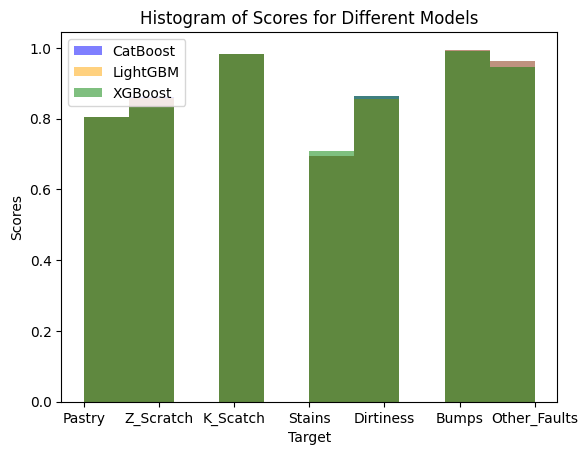

In [19]:
# Define scores for each model
cat_scores = [cat_Bumps_score, cat_Dirtiness_score, cat_K_Scatch_score, cat_Other_Faults_score, cat_Pastry_score, cat_Stains_score, cat_Z_Scratch_score]
lgbm_scores = [lgbm_Bumps_score, lgbm_Dirtiness_score, lgbm_K_Scatch_score, lgbm_Other_Faults_score, lgbm_Pastry_score, lgbm_Stains_score, lgbm_Z_Scratch_score]
xgb_scores = [xgb_Bumps_score, xgb_Dirtiness_score, xgb_K_Scatch_score, xgb_Other_Faults_score, xgb_Pastry_score, xgb_Stains_score, xgb_Z_Scratch_score]

# Create figure and axes
fig, ax = plt.subplots()

# Plot histograms for each model
ax.hist(target_cols, weights=cat_scores, alpha=0.5, label='CatBoost', color='blue')
ax.hist(target_cols, weights=lgbm_scores, alpha=0.5, label='LightGBM', color='orange')
ax.hist(target_cols, weights=xgb_scores, alpha=0.5, label='XGBoost', color='green')

# Set labels and title
ax.set_xlabel('Target')
ax.set_ylabel('Scores')
ax.set_title('Histogram of Scores for Different Models')

# Add legend
ax.legend()

# Show plot
plt.show()

In [20]:
scores = pd.DataFrame({'cat_scores': cat_scores, 'lgbm_scores': lgbm_scores, 'xgb_scores': xgb_scores}, index=target_cols)
scores

,cat_scores,lgbm_scores,xgb_scores
Pastry,0.804759,0.805655,0.803365
Z_Scratch,0.861674,0.859151,0.831675
K_Scatch,0.983599,0.983705,0.982340
Stains,0.694338,0.695419,0.708319
Dirtiness,0.864073,0.854980,0.863678
Bumps,0.994906,0.992886,0.991254
Other_Faults,0.961810,0.962624,0.945028


In [21]:
pastry_predictions = (best_lgbm_model_Pastry.predict_proba(test)[:, 1] + best_xgb_model_Pastry.predict_proba(test)[:, 1] + best_cat_model_Pastry.predict_proba(test)[:, 1]) / 3
Z_Scratch_predictions = (best_lgbm_model_Z_Scratch.predict_proba(test)[:, 1] + best_xgb_model_Z_Scratch.predict_proba(test)[:, 1] + best_cat_model_Z_Scratch.predict_proba(test)[:, 1]) / 3
K_Scatch_predictions = (best_lgbm_model_K_Scatch.predict_proba(test)[:, 1] + best_xgb_model_K_Scatch.predict_proba(test)[:, 1] + best_cat_model_K_Scatch.predict_proba(test)[:, 1]) / 3
Stains_predictions = (best_lgbm_model_Stains.predict_proba(test)[:, 1] + best_xgb_model_Stains.predict_proba(test)[:, 1] + best_cat_model_Stains.predict_proba(test)[:, 1]) / 3
Dirtiness_predictions = (best_lgbm_model_Dirtiness.predict_proba(test)[:, 1] + best_xgb_model_Dirtiness.predict_proba(test)[:, 1] + best_cat_model_Dirtiness.predict_proba(test)[:, 1]) / 3
Bumps_predictions = (best_lgbm_model_Bumps.predict_proba(test)[:, 1] + best_xgb_model_Bumps.predict_proba(test)[:, 1] + best_cat_model_Bumps.predict_proba(test)[:, 1]) / 3
Other_Faults_predictions = (best_lgbm_model_Other_Faults.predict_proba(test)[:, 1] + best_xgb_model_Other_Faults.predict_proba(test)[:, 1] + best_xgb_model_Other_Faults.predict_proba(test)[:, 1]) / 3


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.939940765287339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.939940765287339
[LightGBM] [Warning] lambda_l2 is set=0.0023972954455110497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023972954455110497
[LightGBM] [Warning] lambda_l1 is set=0.002565363377063284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002565363377063284
[LightGBM] [Warning] bagging_fraction is set=0.5035878689258695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5035878689258695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.8390553651081832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8390553651081832
[LightGBM] [Warning] lambda_l2 is set=4.2100349607070426e-05, reg_la

In [22]:
submission_df = pd.DataFrame({
    'Pastry': pastry_predictions,
    'Z_Scratch': Z_Scratch_predictions,
    'K_Scatch': K_Scatch_predictions,
    'Stains': Stains_predictions,
    'Dirtiness': Dirtiness_predictions,
    'Bumps': Bumps_predictions,
    'Other_Faults': Other_Faults_predictions
})

In [23]:
test2 = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
ids = test2['id']
submission_df.insert(0, 'id', ids)
# extra = pd.read_csv('/kaggle/input/extraa/extra.csv')
# submission_df['Stains'] = extra

In [24]:
submission_df

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.380501,0.031837,0.054009,0.000209,0.033952,0.172878,0.340621
1,19220,0.239731,0.040428,0.070854,0.000606,0.122155,0.221034,0.364521
2,19221,0.002316,0.053350,0.083821,0.001420,0.030043,0.324188,0.544305
3,19222,0.106462,0.031832,0.053281,0.001056,0.039266,0.344782,0.399049
4,19223,0.001244,0.031416,0.055444,0.002063,0.026871,0.618729,0.397494
...,...,...,...,...,...,...,...,...
12809,32028,0.044664,0.098929,0.053411,0.000406,0.042958,0.217859,0.408560
12810,32029,0.126088,0.032301,0.075811,0.006789,0.117669,0.196597,0.411600
12811,32030,0.001289,0.031201,0.787519,0.000778,0.022944,0.019618,0.034210
12812,32031,0.446984,0.041829,0.077926,0.000709,0.043920,0.177260,0.357967


In [25]:
submission_df.to_csv('submission.csv', index=False)

### I open each model and combine the predictions with the following approach.


### Determining Weights based on AUC Scores

The weights for averaging can be determined based on the AUC scores of each model. To normalize the AUC scores and use them as weights, follow these steps:

1. **Normalize AUC scores**: Divide each AUC score by the sum of all AUC scores.

     $$ \text{Normalized AUC} = \frac{\text{AUC}}{\sum_{i=1}^{N} \text{AUC}_i}  $$

2. **Use normalized AUC as weights**: The normalized AUC scores obtained from Step 1 are used as weights for averaging.

### Combined Prediction using Weighted Averaging

The combined prediction using weighted averaging can be calculated as follows:

 $$ \text{Combined Prediction} = \frac{\sum_{i=1}^{N} \text{Prediction}_i \times \text{Weight}_i}{\sum_{i=1}^{N} \text{Weight}_i}  $$

In this formula:

-  $ \text{Prediction}_i  $ represents the prediction from the $i $th model.
- $ \text{Weight}_i $ represents the weight assigned to the $ i $th model, calculated based on its AUC score.
- $ N $ represents the total number of models.

This method ensures that the predictions are combined in a weighted manner, where models with higher AUC scores contribute more to the final prediction.
